<a href="https://colab.research.google.com/github/pizzapuppies/Youssif_FYP_Code/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title import packages
! pip install -q -U keras-tuner
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd 
import os
import tensorflow as tf
import numpy as np  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import csv
import random
from tensorflow import keras
import sys
import keras_tuner as kt
from tensorflow.keras import layers
import time
from matplotlib import pyplot as plt

global results


file_path = os.getcwd()

Mounted at /content/gdrive


# setting up the data



In [ ]:
#@title read the data and split it by class

data = {}
with open("/content/gdrive/My Drive/data.csv","r") as rfile:
  reader = csv.reader(rfile)
  line = 0
  for row in reader:
    label = "n" if "n" in  row[0] else row[0]
    if label not in data.keys():
      data[label] = []
      real,imag = list(map(float,row[1:51])),list(map(float,row[51:]))
    data[label].append([real,imag])


dk = list(data.keys())
print("the classes are",dk)
#print(f"in a class there are {len(data[list(dk)[0]])} data points")    

print(len(data["p0.5"]))
  
print(len(data["p0.5"][0]))


the classes are ['p0.5', 'n', 'p1', 'p2', 'p4', 'p8', 'p16', 'p32']
10
2


c is the index in this list:: ['p0.5', 'n0.5', 'p1', 'n1', 'p2', 'n2', 'p4', 'n4', 'p8', 'n8', 'p16', 'n16', 'p32', 'n32']

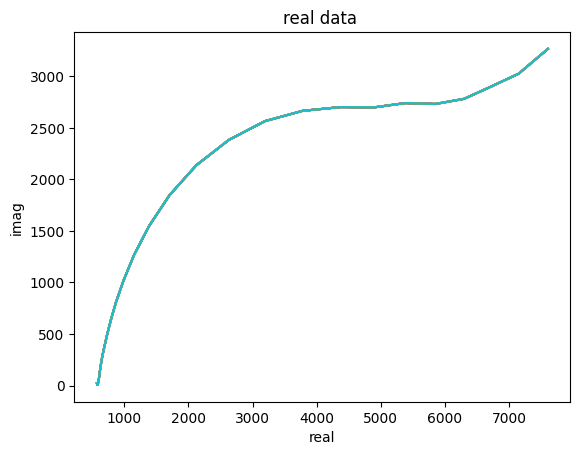

In [ ]:
#@title graph the training data by class
c = 2# don't go over 4
# to pick which class you want
cl = "p32"
li =  data["p32"]
key = "p32"
for i in range(len(data[key])):

  plt.plot(data[key][i][0],data[key][i][1])

plt.title(f"real data ")
plt.ylabel("imag")
plt.xlabel("real")
plt.show()

The generator model only ptroduces values from -1 to 1. Therefore i'm going to normalize (divide them by max) the values of this data 

In [ ]:
#@title normalize the values[0-1] and then give them to the model

flat = np.array(li)
sha = flat.shape
flat = flat.flatten()
mco = max(flat)  # max coefficient
print(mco)
flat = list(map(lambda a: a/mco,flat))
flat = np.array(flat).reshape(sha)


BUFFER_SIZE = 8
BATCH_SIZE = 4
train_dataset = tf.data.Dataset.from_tensor_slices(flat).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print("size of the training dataset", flat.shape)

7602.92
size of the training dataset (10, 2, 50)


# Creating the models

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(2*50, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((2,50)))
    #assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv1DTranspose(128, (5), strides=(1), padding='same', use_bias=False))
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(64, (5), strides=(1), padding='same', use_bias=False))
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(50, (5), strides=(1), padding='same', use_bias=False, activation='tanh'))
    
    return model

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)

(1, 2, 50)


In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, (5), strides=(2), padding='same',
                                     input_shape=[2,50]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(128, (5), strides=(2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(128, (5), strides=(2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(128, (5), strides=(2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00197797]], shape=(1, 1), dtype=float32)


#Creating optimizers and losses function

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

### Generator loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#Define training loop

In [ ]:
EPOCHS = 800_000
noise_dim = 100
num_examples_to_generate = 1000

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      
    #print(generator.trainable_variables)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  
  # final creations
  generate_and_save_images(generator,
                           epochs,
                           seed)

  

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  
  pred = predictions.numpy()


  global results
  results = pred
  txtfile = file_path + f'/results_{cl}_{num_examples_to_generate}' + '.csv'
  with open(txtfile, "w") as wfile:
    writer = csv.writer(wfile)
    for i in range(len(pred)):
      real = list(map(str,pred[i][0]))
      imag = list(map(str,pred[i][1]))
      writer.writerow([cl]+real+imag)
  
  

In [ ]:
train(train_dataset, EPOCHS)

Streaming output truncated to the last 5000 lines.
Time for epoch 134403 is 0.038083553314208984 sec
Time for epoch 134404 is 0.031400203704833984 sec
Time for epoch 134405 is 0.027660846710205078 sec
Time for epoch 134406 is 0.03158712387084961 sec
Time for epoch 134407 is 0.030512571334838867 sec
Time for epoch 134408 is 0.03125357627868652 sec
Time for epoch 134409 is 0.030190229415893555 sec
Time for epoch 134410 is 0.03966498374938965 sec
Time for epoch 134411 is 0.03311014175415039 sec
Time for epoch 134412 is 0.03237509727478027 sec
Time for epoch 134413 is 0.03329133987426758 sec
Time for epoch 134414 is 0.03225135803222656 sec
Time for epoch 134415 is 0.01892375946044922 sec
Time for epoch 134416 is 0.020003318786621094 sec
Time for epoch 134417 is 0.01951146125793457 sec
Time for epoch 134418 is 0.028941631317138672 sec
Time for epoch 134419 is 0.019200801849365234 sec
Time for epoch 134420 is 0.01921701431274414 sec
Time for epoch 134421 is 0.01937103271484375 sec
Time for e

In [ ]:
import pickle
filename = f'/content/gdrive/My Drive/gan_gen/trained_gen_{cl}_{EPOCHS}.sav'
pickle.dump(generator, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
noise = tf.random.normal([1, 100])
generated_image = loaded_model(noise, training=False)


In [ ]:
sha = np.array(generated_image).shape

r = np.array(generated_image).flatten()
r = list(map(lambda a: mco*a, r))

re = np.array(r).reshape(sha)


for i in range(len(re)):
  
  plt.plot(re[i][0],re[i][1])
plt.show()

In [ ]:
sha = np.array(results).shape

r = np.array(results).flatten()
r = list(map(lambda a: mco*a, r))

re = np.array(r).reshape(sha)


for i in range(len(re)):
  
  plt.plot(re[i][0],re[i][1])


plt.title("sysnthetic data")
plt.ylabel("imag")
plt.xlabel("real")
plt.show()
txtfile = "/content/gdrive/My Drive/gan_data" + f'/results_{cl}_{num_examples_to_generate}' + '.csv'
print(txtfile)
with open(txtfile, "w") as wfile:
    writer = csv.writer(wfile)
    for i in range(len(re)):
      real = list(map(str,re[i][0]))
      imag = list(map(str,re[i][1]))
      writer.writerow([cl]+real+imag)